In [1]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Load Dataset
data=pd.read_csv('./penguin_dataset.csv')
data.head()

,island,sex,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,species
0,Torgersen,MALE,39.1,18.7,181,3750,Adelie
1,Torgersen,FEMALE,39.5,17.4,186,3800,Adelie
2,Torgersen,FEMALE,40.3,18.0,195,3250,Adelie
3,Torgersen,FEMALE,36.7,19.3,193,3450,Adelie
4,Torgersen,MALE,39.3,20.6,190,3650,Adelie


In [3]:
#Show Key Statistics
data.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,337.000000,337.000000,337.000000,337.000000
mean,43.991395,17.143323,201.029674,4205.934718
std,5.451934,1.980175,14.049414,804.106149
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.500000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [4]:
#Create One Hot Encoded Dataframe

from sklearn.preprocessing import OneHotEncoder

data_x = data.drop('species',axis=1)
data_y = data['species']

ohe = OneHotEncoder(drop='first')
data_object = data_x.select_dtypes('object')
ohe.fit(data_object)

codes = ohe.transform(data_object).toarray()
feature_names = ohe.get_feature_names_out(data_object.columns)

data_ohe = pd.concat([data_x.select_dtypes(exclude='object'), 
               pd.DataFrame(codes,columns=feature_names).astype(int)], axis=1)

data_ohe_f = pd.concat([data_ohe,data_y],axis=1)

data_ohe_f.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_MALE,sex_nan,species
0,39.1,18.7,181,3750,0,1,1,0,Adelie
1,39.5,17.4,186,3800,0,1,0,0,Adelie
2,40.3,18.0,195,3250,0,1,0,0,Adelie
3,36.7,19.3,193,3450,0,1,0,0,Adelie
4,39.3,20.6,190,3650,0,1,1,0,Adelie


Class Split
Adelie       147
Gentoo       122
Chinstrap     68
Name: species, dtype: int64


Text(0, 0.5, 'Count')

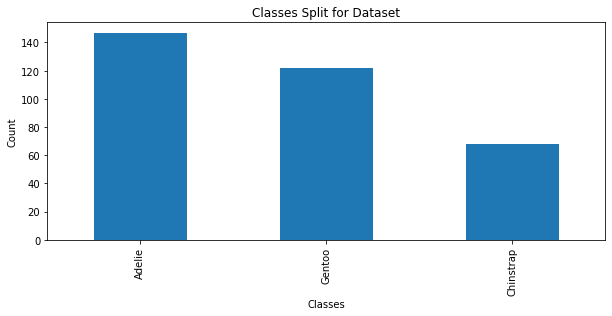

In [5]:
#Class Balance
print('Class Split')
print(data_ohe_f['species'].value_counts())
data_ohe_f['species'].value_counts().plot.bar(figsize=(10,4),title='Classes Split for Dataset')
plt.xlabel('Classes')
plt.ylabel('Count')

In [6]:
#Find Independent Column Correlations
def correlation(dataset,threshold):
    col_corr= [] # List of correlated columns
    corr_matrix=dataset.corr() #finding correlation between columns
    for i in range (len(corr_matrix.columns)): #Number of columns
        for j in range (i):
            if abs(corr_matrix.iloc[i,j])>threshold: #checking correlation between columns
                colName=(corr_matrix.columns[i], corr_matrix.columns[j]) #getting correlated columns
                col_corr.append(colName) #adding correlated column name
    return col_corr #returning set of column names
col=correlation(data_ohe_f,0.8)
print('Correlated columns @ 0.8:', col)

Correlated columns @ 0.8: [('body_mass_g', 'flipper_length_mm')]


In [7]:
#Define x and y variable
x = data_ohe_f.drop('species',axis=1).to_numpy()
y = data_ohe_f['species'].to_numpy()

# Create Train and Test Datasets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,stratify=y,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.transform(x_test)

#Model
from sklearn.linear_model import LogisticRegression

In [8]:
#Base Logistical Regression Model
from sklearn.metrics import classification_report, confusion_matrix  

for name,method in [('LogReg', LogisticRegression(multi_class='multinomial',solver='newton-cg',
                                               random_state=100,max_iter=10000))]: 
    method.fit(x_train2,y_train)
    predict = method.predict(x_test2)
    print('\nEstimator: {}'.format(name)) 
    print(confusion_matrix(y_test,predict))  
    print(classification_report(y_test,predict))          


Estimator: LogReg
[[30  0  0]
 [ 0 14  0]
 [ 0  0 24]]
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



In [9]:
#Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(multi_class='multinomial',solver='newton-cg',
                                               random_state=100,max_iter=10000))])
pipeline.insert(0,pipe_logreg)

#Set grid search params 

modelpara =[]

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l2'],
                   'clf__solver':['newton-cg', 'sag', 'saga' , 'lbfgs']}
modelpara.insert(0,param_gridlogreg)

In [10]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train, 
                                                            y=y_train,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()

Logisistic Regression - Learning Curve


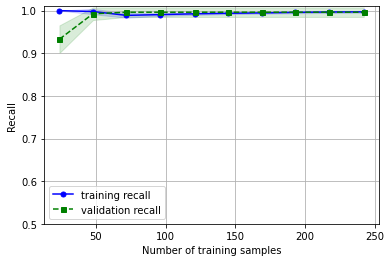

In [11]:
#Plot Learning Curve
print('Logisistic Regression - Learning Curve')
plot_learning_curves(pipe_logreg)

Model Evaluation - Recall
Logistic Regression 1.00 +/- 0.01




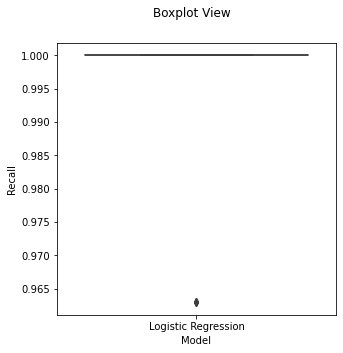

In [12]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Logistic Regression',pipe_logreg))

#Model Evaluation
results =[]
names=[]
scoring ='recall_weighted'
print('Model Evaluation - Recall')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x_train,y_train,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.show()

In [13]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train, y_train)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)
    
    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred))     
    

In [14]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)


Optimized Model

Model Name: LogisticRegression(max_iter=10000, multi_class='multinomial', random_state=100,
                   solver='newton-cg')

Best Parameters: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg'}

 [[30  0  0]
 [ 0 14  0]
 [ 0  0 24]]

               precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        24

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



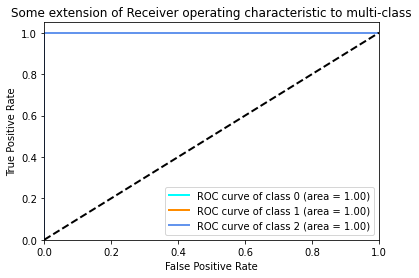

In [15]:
#Creating Multivariable ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

#Binarize the output
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
le = LabelEncoder()
y2 = data_ohe_f['species']
y3= le.fit_transform(y2)
y3 = label_binarize(y3, classes=[0, 1, 2])
x2 = data_ohe_f.drop('species', axis=1).values

#Creating Training and Testing Data
x_train3, x_test3, y_train3, y_test3 = train_test_split(x2, y3, test_size=0.20,stratify=y,random_state=100)
n_classes = y3.shape[1]

#Create ROC Curve
from sklearn.multiclass import OneVsRestClassifier
classOrg = model
classifier = OneVsRestClassifier(model)
y_score = classifier.fit(x_train3, y_train3).predict_proba(x_test3)

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test3[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  
    
#Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

#Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#Plot all ROC curves
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()  

In [16]:
#Next Steps - Feature Selection using SelectFromModel
from sklearn.feature_selection import SelectFromModel
clf = LogisticRegression(solver='lbfgs',class_weight='balanced',
                                            random_state=100)
clf.fit(x_train2,y_train)
model = SelectFromModel(clf, prefit=True)
feature_idx = model.get_support()
feature_name = data_ohe_f.drop('species',axis=1).columns[feature_idx]
print('\nKey Features:',feature_name)


Key Features: Index(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'island_Dream'],
      dtype='object')
